# The assignment
is to implement a deep reinforcement learning algorithm in python3 and pytorch where the agent successfully plays Banana Game, a game where the agent has to collect yellow bananas while avoiding blue bananas. I have adapted DQN with experienced replay algorithm and vary some of the hyperparameters to obtain the best performance.

# What is DQN with experienced replay?
DQN  algorithm uses two separate networks with identical architectures: two fully connected layers and the choice to include batch normalization. The target Q-networks weights are updated less often than the primary Q-network weights, specifically 1 update every 4 iterations, in order to avoid correlation between the parameters we are looking for and the parameters of the target. O

Another improvement with respect to vanilla DQN in order to avoid correlation between the sequence of experience tuples and helping the agent to learn, so that it does not get stack in tuples the agent is no longer learning from. Experienced replay keeps track of a replay buffer (memory) , and then sample from this buffer at random. Another advantage of experienced replay is that it allows us to learn more from individual tuples multiple times

# 0. Installation of requirements

In [4]:
!pip install ./python

Processing ./python
    100% |████████████████████████████████| 48.1MB 934kB/s eta 0:00:01
    100% |████████████████████████████████| 6.4MB 6.3MB/s eta 0:00:01
    100% |████████████████████████████████| 8.8MB 6.2MB/s eta 0:00:01
    100% |████████████████████████████████| 102kB 19.7MB/s a 0:00:01
    100% |████████████████████████████████| 3.1MB 12.1MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 30.3MB/s ta 0:00:01
    100% |████████████████████████████████| 337kB 21.4MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 16.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for unityagents ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8rothyc/wheels/97/7a/24/09937717b9737178ae827bcef33ba219b540efd55be210010c
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /root/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /root

# 1. Loading libraries and exploring de space

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Examine the State and Action Spaces



In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


# 2a.- Run model for several hypermarameters and save model weights, and dictionary of model rewards for later use

Define DQN episodes 

In [9]:
from dqn_agent import Agent
from time import sleep


def dqn_bananas(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,model_name="",is_bn=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]      
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]    
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'finalmodel_checkpoint_'+model_name+'.pth')
            break
    return scores


Learn the game for several hyperparameters

In [10]:
import pandas as pd
eps_ini=[1,0.5]
eps_fin=[0.1,0.01]
max_ts=[1000,10000,50000]
isbns=[False]
nepisodes=1000
df=pd.DataFrame(columns=['r','bn','maxt','eps2','eps1'])
scores_dic={}
for isbn in isbns:
    BATCH_NORM=isbn
    scores_dic[isbn]={}
    for maxt in max_ts:
        scores_dic[isbn][maxt]={}
        for epsfin in eps_fin:
            scores_dic[isbn][maxt][epsfin]={}
            for epsini in eps_ini:
                scores_dic[isbn][maxt][epsfin][epsini]={}
                modelname="bn_"+str(isbn)+"_maxt_"+str(maxt)+"_eps2_"+str(epsfin)+"_eps1_"+str(epsini)
                scores_dic[isbn][maxt][epsfin][epsini] = dqn_bananas(n_episodes=nepisodes,max_t=maxt,eps_end=epsfin,model_name=modelname) #seed = 10
                row=pd.DataFrame({'r':[scores_dic[isbn][maxt][epsfin][epsini]]
                                  ,'bn':[isbn]
                                 ,'maxt':[maxt]
                                 ,'eps2':[epsfin]
                                 ,'eps1':[epsini]})
                df=df.append(row,ignore_index=True)
df.to_pickle('finaldf_r.p')

#When finished, you can close the environment.
env.close()

Episode 100	Average Score: 1.12
Episode 200	Average Score: 4.88
Episode 300	Average Score: 8.34
Episode 400	Average Score: 10.43
Episode 489	Average Score: 13.02
Environment solved in 389 episodes!	Average Score: 13.02
Episode 100	Average Score: 0.80
Episode 200	Average Score: 3.58
Episode 300	Average Score: 7.69
Episode 400	Average Score: 10.99
Episode 477	Average Score: 13.02
Environment solved in 377 episodes!	Average Score: 13.02
Episode 100	Average Score: 0.55
Episode 200	Average Score: 4.28
Episode 300	Average Score: 7.75
Episode 400	Average Score: 9.74
Episode 500	Average Score: 12.42
Episode 530	Average Score: 13.02
Environment solved in 430 episodes!	Average Score: 13.02
Episode 100	Average Score: 1.04
Episode 200	Average Score: 4.76
Episode 300	Average Score: 7.71
Episode 400	Average Score: 10.35
Episode 497	Average Score: 13.01
Environment solved in 397 episodes!	Average Score: 13.01
Episode 100	Average Score: 1.01
Episode 200	Average Score: 4.75
Episode 300	Average Score: 8

# 2b. - Load rewards dictionary and best model

Load dataframe of rewards list for different hyperparameters and creates a dataframe with columns episodes and average reward over 100 episodes.

In [24]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as  np

df=pd.read_pickle('finaldf_r.p')
df.loc[:,'r_proc']=df.r.apply(lambda x: np.sum(x[-100:])/100.)

#best_model=torch.load("checkpoint_bn_False_maxt_10000_eps2_0.01_eps1_0.5.pth")

In [19]:
df2=pd.DataFrame(columns=['maxt','eps2','eps1','ep','r'])
for i in range(10):
    j=(i+1)*100
    df_extra=df[['maxt','eps2','eps1']]
    df_extra.loc[:,'ep']=df.r.apply(lambda x: j)
    df_extra.loc[:,'r']=df.r.apply(lambda x: np.sum(x[j-100:j])/100.)
    #print(j,len(df_extra))
    df2=df2.append(df_extra,ignore_index=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Plots the evolution of rewards for models with different hyperparameters por starting and ending episode, and time steps. We observe there is no model that remarkably differentiates with the rest. Most of them reach an average score of 13 around iteration 500. If we have to choose, starting epsilon would be 1 instead of 0.5, ending epsilon would be 0.5 and 1000 time steps per episode would be enough.

(0, 505)

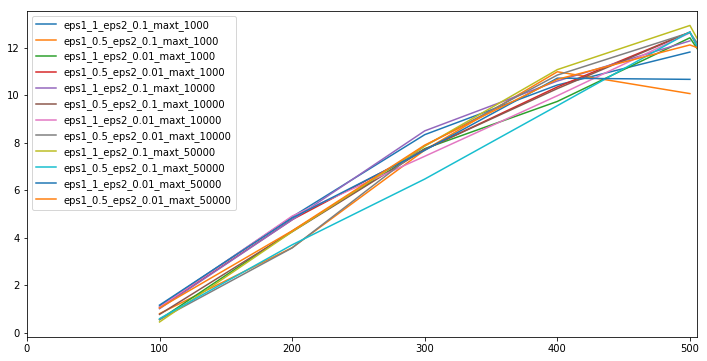

In [58]:
df2b=df2[df2.r!=0]

eps_ini=[1,0.5]
eps_fin=[0.1,0.01]
max_ts=[1000,10000,50000]

fig,ax=plt.subplots(1,figsize=(12,6))
for maxt in max_ts:
    for epsfin in eps_fin:
        for epsini in eps_ini:
                
            sub=df2b[(df2b.maxt==maxt)&(df2b.eps1==epsini)&(df2b.eps2==epsfin)]
            ax.plot(sub.ep,sub.r,label='eps1_'+str(epsini)+'_eps2_'+str(epsfin)+'_maxt_'+str(maxt))
ax.legend()
ax.set_xlim([0,505])

## 3. Load and download the saved model weights to watch the agent on your own machine! 

In [60]:
torch.load("./checkpoint_bn_False_maxt_1000_eps2_0.1_eps1_1.pth")
LOCAL_PATH=""
torch.save(LOCAL_PATH)